In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)

In [3]:
def euler_predictor_func(state, past_control, D, dt, dynamics_func, previous_predictor):
    # Just do Euler's method for now
    guess = np.copy(state)
    nD = int(round(D / dt))
    prev_preds = np.copy(previous_predictor)
    for i in range(0, nD):
        guess += dynamics_func(prev_preds[i], past_control[i]) * dt
    return guess


def dynamics_func(current_state, control):
    return np.array([current_state[1] - current_state[1] ** 2 * control, control])


def control_func(state):
    return -state[0] - 2 * state[1] - (1.0 / 3.0) * state[1] ** 3


def explicit_control_func(init_states, t, D):
    z1 = init_states[0]
    z2 = init_states[1]
    return -np.exp(-(t - D)) * (
                (z1 + (2 + D) * z2 + (1.0 / 3.0) * z2 ** 3) - (t - D) * (z1 + (1 + D) * z2 + (1.0 / 3.0) * z2 ** 2))


def explicit_predictor_func(state, past_control, D, dt, _a, _b):
    z1 = state[0]
    z2 = state[1]
    nD = int(round(D / dt))
    int1 = 0
    for i in range(0, nD):
        int1 += (D - (dt * i)) * past_control[i]
    int1 *= dt
    int2 = sum(past_control) * dt
    p1 = z1 + D * z2 + int1 - z2 ** 2 * int2 - z2 * int2 ** 2 - (1.0 / 3.0) * int2 ** 3
    p2 = z2 + int2
    return [p1, p2]


def no_predictor_func(state, past_controls, _a, _b, model, _d):
    inp = np.concatenate([state, past_controls.flatten()]).ravel()
    inp = np.reshape(inp, (1, len(inp)))
    inp = torch.from_numpy(inp).float()
    grid = np.linspace(0, inp.shape[1] - 1, inp.shape[1], dtype=np.float32)
    grid = np.reshape(grid, (len(grid), 1))
    grid = torch.from_numpy(grid)
    pred = model(inp, grid)
    return pred.detach().cpu().numpy().flatten()


def getl2error(true, estimate):
    if len(true[0]) > 1:
        res = []
        for idx in range(0, len(true)):
            res.append(np.linalg.norm(true[idx] - estimate[idx]))
        return np.linalg.norm(res, ord=2)
    else:
        return np.linalg.norm(true - estimate, ord=2)


def getTrueSoln(init_states, T, dt, D, dynamics_func, control_func, debug=True):
    t = np.linspace(0, T, int(round(T / dt)))
    nt = len(t)
    nx = len(init_states)
    nD = int(round(D / dt))
    out = np.zeros((nt, nx))
    control_arr = []
    out[0] = init_states
    # USE Euler to start
    for i in range(1, nt):
        control = control_func(init_states, dt * (i - 1), D)
        if dt * i <= 3:
            out[i] = out[i - 1] + dt * dynamics_func(out[i - 1], 0)
        else:
            control_arr.append(control)
            out[i] = out[i - 1] + dt * dynamics_func(out[i - 1], control)
    for i in range(nt, nt + int(round(D / dt))):
        control_arr.append(control_func(init_states, dt * (i - 1), D))
    return out, np.array(control_arr)


def simulateODEPredictor(init_states, T, dt, D, dynamics_func, predictor_func, control_func, debug=False):
    t = np.linspace(0, T, int(round(T / dt)))
    nt = len(t)
    nx = len(init_states)
    nD = int(round(D / dt))
    out = np.zeros((nt, nx))
    pred_arr = []
    control_arr = []
    out[0] = init_states
    past_controls = np.zeros((nD))
    # Get previous predictors as the initial states
    prev_predictors = np.zeros((nD, nx))
    prev_predictors[:] = init_states
    predictor_inputs = []
    # USE Euler to start
    for i in range(1, nt):
        prediction = predictor_func(out[i - 1], past_controls, D, dt, dynamics_func, prev_predictors)
        control = control_func(prediction)
        predictor_input = np.concatenate([out[i - 1], past_controls.flatten()]).ravel()
        past_controls = np.roll(past_controls, -1)
        past_controls[-1] = control
        prev_predictors[:-1] = prev_predictors[1:]
        prev_predictors[-1] = prediction
        control_arr.append(control)
        pred_arr.append(prediction)
        predictor_inputs.append(predictor_input)
        out[i] = out[i - 1] + dt * dynamics_func(out[i - 1], past_controls[0])
        if debug == True:
            print("plant (t-1)", out[i - 1])
            print("plant (t)", out[i])
            print("Control", past_controls[0])
            print("Predictor", prediction)
    return out, np.array(pred_arr), np.array(control_arr), np.array(predictor_inputs)


def simulateODENOPPredictor(init_states, T, dt, D, dynamics_func, predictor_func, control_func, model, debug=False):
    t = np.linspace(0, T, int(round(T / dt)))
    nt = len(t)
    nx = len(init_states)
    nD = int(round(D / dt))
    out = np.zeros((nt, nx))
    pred_arr = []
    control_arr = []
    out[0] = init_states
    past_controls = np.zeros((nD))
    # Get previous predictors as the initial states
    prev_predictors = np.zeros((nD, nx))
    prev_predictors[:] = init_states
    predictor_inputs = []
    # USE Euler to start
    for i in range(1, nt):
        prediction = predictor_func(out[i - 1], past_controls, D, dt, model, prev_predictors)
        control = control_func(prediction)
        predictor_input = np.concatenate([out[i - 1], past_controls.flatten()]).ravel()
        past_controls = np.roll(past_controls, -1)
        past_controls[-1] = control
        prev_predictors[:-1] = prev_predictors[1:]
        prev_predictors[-1] = prediction
        control_arr.append(control)
        pred_arr.append(prediction)
        predictor_inputs.append(predictor_input)
        out[i] = out[i - 1] + dt * dynamics_func(out[i - 1], past_controls[0])
        if dt * i % (int(nt / 10)) == 0:
            print("Iteration:", i, "5", nt)
        if debug == True:
            print("plant (t-1)", out[i - 1])
            print("plant (t)", out[i])
            print("Control", past_controls[0])
            print("Predictor", prediction)
    return out, np.array(pred_arr), np.array(control_arr), np.array(predictor_inputs)


def simulateODENOPWarmStartPredictor(init_states, T, dt, D, dynamics_func, predictor_func, control_func, model,
                                     debug=False):
    t = np.linspace(0, T, int(round(T / dt)))
    nt = len(t)
    nx = len(init_states)
    nD = int(round(D / dt))
    out = np.zeros((nt, nx))
    pred_arr = []
    control_arr = []
    out[0] = init_states
    past_controls = np.zeros((nD))
    # Get previous predictors as the initial states
    prev_predictors = np.zeros((nD, nx))
    prev_predictors[:] = init_states
    predictor_inputs = []
    # USE Euler to start
    for i in range(1, nt):
        if i * dt < D:
            prediction = euler_predictor_func(out[i - 1], past_controls, D, dt, dynamics_func, prev_predictors)
        else:
            prediction = predictor_func(out[i - 1], past_controls, D, dt, model, prev_predictors)
        control = control_func(prediction)
        predictor_input = np.concatenate([out[i - 1], past_controls.flatten()]).ravel()
        past_controls = np.roll(past_controls, -1)
        past_controls[-1] = control
        prev_predictors[:-1] = prev_predictors[1:]
        prev_predictors[-1] = prediction
        control_arr.append(control)
        pred_arr.append(prediction)
        predictor_inputs.append(predictor_input)
        out[i] = out[i - 1] + dt * dynamics_func(out[i - 1], past_controls[0])
        if dt * i % (int(nt / 10)) == 0:
            print("Iteration:", i, "5", nt)
        if debug == True:
            print("plant (t-1)", out[i - 1])
            print("plant (t)", out[i])
            print("Control", past_controls[0])
            print("Predictor", prediction)
    return out, np.array(pred_arr), np.array(control_arr), np.array(predictor_inputs)

In [6]:
T = 15
dt = 0.01
D = 3
nt = int(round(T/dt))
init_states = np.array([0, 1])
#zArrTrue, controlArrTrue = getTrueSoln(init_states, T, dt, D, dynamics_func, explicit_control_func)
zArrTrue2, predictArrTrue2, controlArrTrue2, _ = simulateODEPredictor(init_states, T, dt, D, dynamics_func, explicit_predictor_func, control_func)
# zArrEuler, predictArrEuler, controlArrEuler, _ = simulateODEPredictor(init_states, T, dt, D, dynamics_func, euler_predictor_func, control_func, model)
# zArrNOP, predictArrNOP, controlArrNOP, _ = simulateODENOPPredictor(init_states, T, dt, D, dynamics_func, no_predictor_func, control_func, model)
# zArrNOPWS, predictArrNOPWS, controlArrNOPWS, _ = simulateODENOPWarmStartPredictor(init_states, T, dt, D, dynamics_func, no_predictor_func, control_func)

In [469]:
# Add shift to U(t)
shift = np.zeros(int(round(D/dt)))
controlArrTrue2Shift = np.concatenate((shift, controlArrTrue2))
controlArrEulerShift = np.concatenate((shift, controlArrEuler))
controlArrNOPShift = np.concatenate((shift, controlArrNOP))
# controlArrNOPWSShift = np.concatenate((shift, controlArrNOPWS))

In [477]:
print("Z state error Euler", getl2error(zArrTrue2, zArrEuler))
print("Z state error NOP", getl2error(zArrTrue2, zArrNOP))

print("P predictor error Euler", getl2error(predictArrTrue2, predictArrEuler))
print("P predictor error NOP", getl2error(predictArrTrue2, predictArrNOP))

print("U control error Euler", getl2error(predictArrTrue2, predictArrEuler))
print("U control error NOP", getl2error(predictArrTrue2, predictArrNOP))

Z state error Euler 0.7682093596642258
Z state error NOP 1.0130885502511529
P predictor error Euler 1.3709457076951135
P predictor error NOP 0.3985203933568555
U control error Euler 1.3709457076951135
U control error NOP 0.3985203933568555


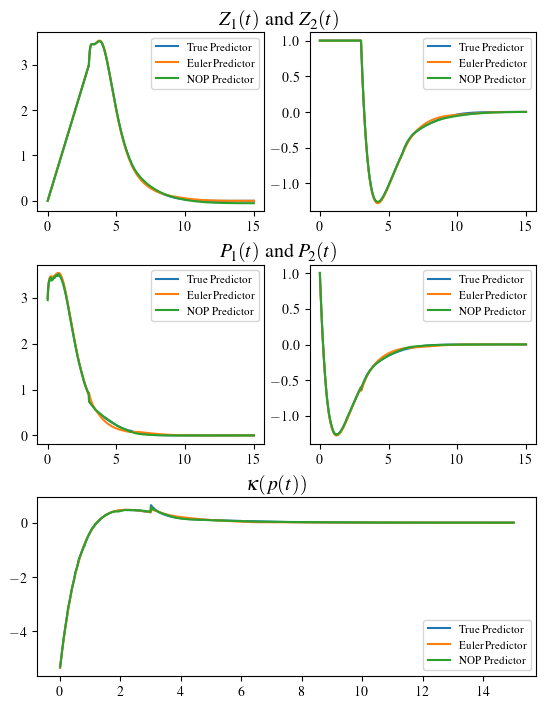

In [485]:
res = 1
t = np.linspace(0, T, len(zArrEuler))

fig = plt.figure(figsize=set_size(470, 0.99, (3,2), height_add=1))

subfigs = fig.subfigures(nrows=3, ncols=1, hspace=10)


subfig = subfigs[0]
subfig.suptitle(r"$Z_1(t)$ and $Z_2(t)$") 

axes = subfig.subplots(nrows=1, ncols=2)
axes[0].plot(t, zArrTrue2[:, 0], label="True Predictor")
axes[0].plot(t, zArrEuler[:, 0], label="Euler Predictor")
axes[0].plot(t, zArrNOP[:, 0], label="NOP Predictor")
# axes[0].plot(t, zArrNOPWS[:, 0], label="NOP Predictor with Euler Warm Start")

axes[1].plot(t, zArrTrue2[:, 1], label="True Predictor")
axes[1].plot(t, zArrEuler[:, 1], label="Euler Predictor")
axes[1].plot(t, zArrNOP[:, 1], label="NOP Predictor")
# axes[1].plot(t, zArrNOPWS[:, 1], label="NOP Predictor with Euler Warm Start")

axes[0].legend()
axes[1].legend()

subfig = subfigs[1]
subfig.suptitle(r"$P_1(t)$ and $P_2(t)$") 

axes = subfig.subplots(nrows=1, ncols=2)
axes[0].plot(t[1:], predictArrTrue2[:, 0], label="True Predictor")
axes[0].plot(t[1:], predictArrEuler[:, 0], label="Euler Predictor")
axes[0].plot(t[1:], predictArrNOP[:, 0], label="NOP Predictor")
# axes[0].plot(t[1:], predictArrNOP[:, 0], label="NOP Predictor with Euler Warm Start")


axes[1].plot(t[1:], predictArrTrue2[:, 1], label="True Predictor")
axes[1].plot(t[1:], predictArrEuler[:, 1], label="Euler Predictor")
axes[1].plot(t[1:], predictArrNOP[:, 1], label="NOP Predictor")
# axes[1].plot(t[1:], predictArrNOP[:, 1], label="NOP Predictor with Euler Warm Start")


axes[0].legend()
axes[1].legend()

subfig = subfigs[2]
subfig.suptitle(r"$\kappa(p(t))$") 

axes = subfig.subplots(nrows=1, ncols=1)
#axes.plot(t[1:], controlArrTrue, label="True Control")
#axes.plot(t[1:], controlArrTrue2Shift[:nt-1], label="True Predictor")
#axes.plot(t[1:], controlArrEulerShift[:nt-1], label="Euler Predictor")
#axes.plot(t[1:], controlArrNOPShift[:nt-1], label="NOP Predictor")
axes.plot(t[1:], controlArrTrue2[:nt-1], label="True Predictor")
axes.plot(t[1:], controlArrEuler[:nt-1], label="Euler Predictor")
axes.plot(t[1:], controlArrNOP[:nt-1], label="NOP Predictor")
# axes.plot(t[1:], controlArrNOPWSShift[:nt-1], label="NOP Predictor with Euler Warm Start")


axes.legend()
plt.savefig("states.pdf", dpi=300)

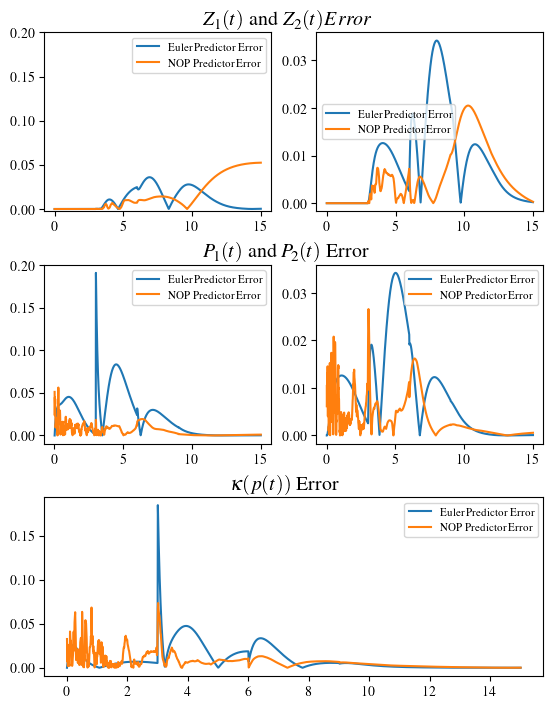

In [486]:
res = 1
t = np.linspace(0, T, len(zArrEuler))

fig = plt.figure(figsize=set_size(470, 0.99, (3,2), height_add=1))

subfigs = fig.subfigures(nrows=3, ncols=1, hspace=10)


subfig = subfigs[0]
subfig.suptitle(r"$Z_1(t)$ and $Z_2(t) Error$") 

axes = subfig.subplots(nrows=1, ncols=2)
axes[0].plot(t,  abs(zArrTrue2[:, 0]-zArrEuler[:, 0]), label="Euler Predictor Error")
axes[0].plot(t, abs(zArrTrue2[:, 0]- zArrNOP[:, 0]), label="NOP Predictor Error")
# axes[0].plot(t, zArrNOPWS[:, 0], label="NOP Predictor with Euler Warm Start")
axes[0].set_yticks([0, 0.05, 0.1, 0.15, 0.2])

axes[1].plot(t, abs( zArrTrue2[:, 1]-zArrEuler[:, 1]), label="Euler Predictor Error")
axes[1].plot(t, abs(zArrTrue2[:, 1]- zArrNOP[:, 1]), label="NOP Predictor Error")
# axes[1].plot(t, zArrNOPWS[:, 1], label="NOP Predictor with Euler Warm Start")

axes[0].legend()
axes[1].legend()

subfig = subfigs[1]
subfig.suptitle(r"$P_1(t)$ and $P_2(t)$ Error") 

axes = subfig.subplots(nrows=1, ncols=2)
axes[0].plot(t[1:], abs(predictArrTrue2[:, 0]-predictArrEuler[:, 0]), label="Euler Predictor Error")
axes[0].plot(t[1:], abs(predictArrTrue2[:, 0]-predictArrNOP[:, 0]), label="NOP Predictor Error")
# axes[0].plot(t[1:], predictArrNOP[:, 0], label="NOP Predictor with Euler Warm Start")


axes[1].plot(t[1:], abs(predictArrTrue2[:, 1]-predictArrEuler[:, 1]), label="Euler Predictor Error")
axes[1].plot(t[1:], abs(predictArrTrue2[:, 1]-predictArrNOP[:, 1]), label="NOP Predictor Error")
# axes[1].plot(t[1:], predictArrNOP[:, 1], label="NOP Predictor with Euler Warm Start")
axes[0].set_yticks([0, 0.05, 0.1, 0.15, 0.2])

axes[0].legend()
axes[1].legend()

subfig = subfigs[2]
subfig.suptitle(r"$\kappa(p(t))$ Error") 

axes = subfig.subplots(nrows=1, ncols=1)
#axes.plot(t[1:], controlArrTrue, label="True Control")
#axes.plot(t[1:], controlArrTrue2Shift[:nt-1], label="True Predictor")
#axes.plot(t[1:], controlArrEulerShift[:nt-1], label="Euler Predictor")
#axes.plot(t[1:], controlArrNOPShift[:nt-1], label="NOP Predictor")
axes.plot(t[1:], abs(controlArrTrue2[:nt-1]- controlArrEuler[:nt-1]), label="Euler Predictor Error")
axes.plot(t[1:],abs(controlArrTrue2[:nt-1]- controlArrNOP[:nt-1]), label="NOP Predictor Error")
# axes.plot(t[1:], controlArrNOPWSShift[:nt-1], label="NOP Predictor with Euler Warm Start")


axes.legend()
plt.savefig("errors.pdf")

In [391]:
# Dataset Generation 
nData =20
T =15
dt = 0.01
D = 3
xData = []
yData = []
for i in range(nData):
    init_states = np.array([0, np.random.uniform(0,2)])
    _, predictOutput,_, predictInput = simulateODEPredictor(init_states, T, dt, D, dynamics_func, explicit_predictor_func, control_func)
    #sampleIdxs = np.random.randint(0, len(predictOutput), size=(10))
    #if i%10 == 0:
    #    print("Completed", i, "/", nData)
    #sampleIdxs = np.linspace(300, len(predictOutput)-1, len(predictOutput)-300, dtype=np.int64)
    sampleIdxs = np.linspace(0, len(predictOutput)-1, len(predictOutput), dtype=np.int64)
    for val in sampleIdxs:
        xData.append(predictInput[val])
        yData.append(predictOutput[val])
xData = np.array(xData)
yData = np.array(yData)
np.savetxt("x.dat", xData)
np.savetxt("y.dat", yData)
print(xData.shape)
print(yData.shape)

(29980, 302)
(29980, 2)


In [392]:
epochs =500
ntrain = 900
ntest = 100
batch_size = 50
gamma = 0.5
learning_rate = 0.001
step_size= 50

In [393]:
# Create train/test splits
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cpu'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cpu'))

(29980, 302)
(29980, 2)


In [394]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [458]:
class DeepONetProjected(torch.nn.Module):
    def __init__(self, dim_x, m, proj_size):
        super().__init__()
        self.deeponet = dde.nn.DeepONetCartesianProd([m, 64, 64], [1, 64, 64], "relu", "Glorot normal")
        self.fc1 = torch.nn.Linear(m, 128)
        self.activation = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128, proj_size)
        
    def forward(self, x, grid):
        out =self.deeponet((x, grid))
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        return out

In [467]:
grid = np.linspace(0, x_train.shape[1]-1, x_train.shape[1], dtype=np.float32)
grid = np.reshape(grid, (len(grid), 1))
grid = torch.from_numpy(grid)
model = DeepONetProjected(1, x_train.shape[1], 2)
model.load_state_dict(torch.load("nopPredictorDeepONet"))
print(grid.shape)
print(count_params(model))

torch.Size([302, 1])
66883


In [397]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [398]:
loss = torch.nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x, y
        optimizer.zero_grad()
        out = model(x, grid)
        
        lp = loss(out, y)
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x, y
            
            out = model(x, grid)
            test_loss += loss(out, y).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%5 == 0:
        print(ep, t2-t1, train_loss, test_loss)

0 0.6580710479756817 4.307151007624688 0.2375150606657068
5 0.6075884170131758 0.1369939562709381 0.1434886749756212
10 0.6065083540743217 0.11616905654642593 0.1286130762503793
15 0.6082697780802846 0.052741766277392375 0.059512265369994564
20 0.6091008660150692 0.01875799295753327 0.02082244412158616
25 0.6095701759913936 0.009034422906147989 0.01491545032185968
30 0.6095659629208967 0.023639265120706382 0.014372974105450945
35 0.6090275519527495 0.07793207291634409 0.049583700004344186
40 0.6096032219938934 0.022653818575458395 0.019059524855886897
45 0.610719189979136 0.03726806409863962 0.03310923693158353
50 0.60894434095826 0.005909426269796246 0.011385350530811895
55 0.6129044430563226 0.005483530243994513 0.010305897885700688
60 0.6093233790015802 0.006249200889228463 0.009109183820692123
65 0.6107444779481739 0.0055609257473271875 0.009023444353564022
70 0.6100641719531268 0.007429127831656606 0.01947953208970527
75 0.6117462989641353 0.00590130761422053 0.006367811325859899


Avg Epoch Time: 0.6449522097939625
Final Testing Loss: 7.491254727938212e-05
Final Training Loss: 6.634597228488322e-05


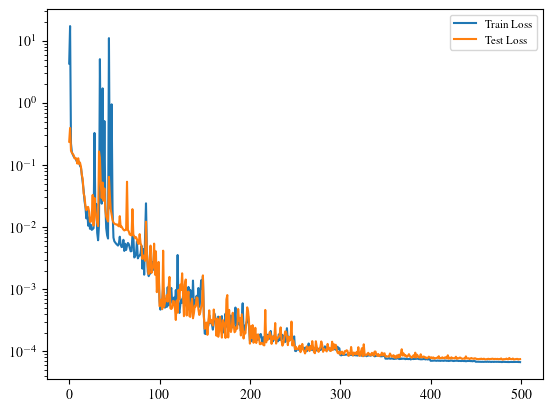

In [399]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:

        out = model(x, grid)
        trainLoss += loss(out, y).item()
        
    for x, y in testData:

        out = model(x, grid)
        testLoss += loss(out, y).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss/len(testData))
print("Final Training Loss:", trainLoss/len(trainData))

In [428]:
torch.save(model.state_dict(), "nopPredictorDeepONet")

In [466]:
# Speed comparison
D = 3
with torch.no_grad():
    dt = 0.01
    nD = int(round(D/dt))
    past_controls = np.zeros((nD))
    init_state = np.zeros(2)
    prev_predictors = np.zeros((nD, len(init_state)))
    prev_predictors[:] = init_states
    model = DeepONetProjected(1, len(init_state)+nD, 2)
    model.eval()
    t1euler = time.time()
    for i in range(100):
        euler_predictor_func(init_state, past_controls, D, dt, dynamics_func, prev_predictors)
    t2euler = time.time()
    print("Results for dt=", dt)
    print("Average time for Euler over 100 instances:", (t2euler-t1euler)/100)
    t1nop = time.time()
    for i in range(100):
        no_predictor_func(init_state, past_controls, D, dt, model, prev_predictors)
    t2nop = time.time()
    print("Average time for NOP over 100 instances:", (t2nop-t1nop)/100)
    print("Speedup", (t2euler-t1euler)/(t2nop-t1nop))

    dt = 0.001
    nD = int(round(D/dt))
    past_controls = np.zeros((nD))
    init_state = np.zeros(2)
    prev_predictors = np.zeros((nD, len(init_state)))
    prev_predictors[:] = init_states
    model = DeepONetProjected(1, len(init_state)+nD, 2)
    model.eval()
    t1euler = time.time()
    for i in range(100):
        euler_predictor_func(init_state, past_controls, D, dt, dynamics_func, prev_predictors)
    t2euler = time.time()
    print("Results for dt=", dt)
    print("Average time for Euler over 100 instances:", (t2euler-t1euler)/100)
    t1nop = time.time()
    for i in range(100):
        no_predictor_func(init_state, past_controls, D, dt, model, prev_predictors)
    t2nop = time.time()
    print("Average time for NOP over 100 instances:", (t2nop-t1nop)/100)
    print("Speedup", (t2euler-t1euler)/(t2nop-t1nop))

    dt = 0.0001
    nD = int(round(D/dt))
    past_controls = np.zeros((nD))
    init_state = np.zeros(2)
    prev_predictors = np.zeros((nD, len(init_state)))
    prev_predictors[:] = init_states
    model = DeepONetProjected(1, len(init_state)+nD, 2)
    model.eval()
    t1euler = time.time()
    for i in range(100):
        euler_predictor_func(init_state, past_controls, D, dt, dynamics_func, prev_predictors)
    t2euler = time.time()
    print("Results for dt=", dt)
    print("Average time for Euler over 100 instances:", (t2euler-t1euler)/100)
    t1nop = time.time()
    for i in range(100):
        no_predictor_func(init_state, past_controls, D, dt, model, prev_predictors)
    t2nop = time.time()
    print("Average time for NOP over 100 instances:", (t2nop-t1nop)/100)
    print("Speedup", (t2euler-t1euler)/(t2nop-t1nop))

Results for dt= 0.01
Average time for Euler over 100 instances: 0.00041214227676391604
Average time for NOP over 100 instances: 0.000142824649810791
Speedup 2.88565228278107
Results for dt= 0.001
Average time for Euler over 100 instances: 0.0040869307518005375
Average time for NOP over 100 instances: 0.0003574752807617187
Speedup 11.432764646249066
Results for dt= 0.0001
Average time for Euler over 100 instances: 0.03756145715713501
Average time for NOP over 100 instances: 0.0025495433807373046
Speedup 14.732621316007018
